In [1]:
import pandas as pd
import json

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#   'font.size': 8,
#   'text.usetex': True,
#   'text.latex.preamble': r'\usepackage{amsmath}',
#   'pgf.texsystem': "pdflatex",
#   'pgf.preamble': r'\usepackage{amsfonts}',
#   #"font.family": "serif",
#   #"pgf.rcfonts": False,
# })

In [3]:
fig_width=6
fig_height=1.5
compiler="clang++13.0.1"

throughput_key="items_per_second"
hash_key="hash"
reducer_key="reducer"
order_key="order"
bits_key="bits"
dataset_key="dataset"
dataset_size_key="dataset_size"
buckets_key="buckets"

In [4]:
def hashfn_name(h):
    return {'MultFibonacci32': "Fibonacci",
        'MultFibonacci64': "Fibonacci",
        'MultFibonacciPrime32': "FibonacciPrime",
        'MultFibonacciPrime64': "FibonacciPrime",
        'MultHash32': "Multiplicative",
        'MultHash64': "Multiplicative",
        'aqua0_32': "AquaHash",
        'aqua0_64': "AquaHash",
        'city128_low': "CityHash128D",
        'city128_upp': "CityHash128U",
        'city32': "CityHash",
        'city64': "CityHash",
        'meow128_low': "MeowHashD",
        'meow128_upp': "MeowHashU",
        'meow32': "MeowHash",
        'meow64_low': "MeowHashD",
        'murmur_finalizer32': "Murmur3",
        'murmur_finalizer64': "Murmur3",
        'tabulation_1x255_32': "TabulationS",
        'tabulation_1x255_64': "TabulationS",
        'tabulation_4x255_32': "TabulationM",
        'tabulation_4x255_64': "TabulationM",
        'tabulation_8x255_64': "TabulationL",
        'xxh3_32': "XXHash",
        'xxh3_64': "XXHash"}[h]

def bits(h):
    if h in {'MultFibonacci32',
                'MultFibonacciPrime32',
                'MultHash32',
                'aqua0_32',
                'city32',
                'meow32',
                'murmur_finalizer32',
                'tabulation_1x255_32',
                'tabulation_4x255_32',
                'xxh3_32'}:
        return 32
    return 64

def reducer_name(r):
    return {None: "None",
            'branchless_fast_modulo32': "Branchless Fast Modulo",
            'branchless_fast_modulo64': "Branchless Fast Modulo",
            'do_nothing32': "Identity",
            'do_nothing64': "Identity",
            'fast_modulo32': "Fast Modulo",
            'fast_modulo64': "Fast Modulo",
            'fastrange32': "Fastrange",
            'fastrange64': "Fastrange",
            'modulo32': "Modulo",
            'modulo64': "Modulo"}[r]

def dataset_name(d):
    return {'books': "amazon", 
            'fb': "facebook", 
            'gap_10': "gapped 10%",
            'osm': "open street map",
            'seq': "sequential",
            'uniform': "uniform",
            'wiki': "wikipedia"}[d]

def do_order(h):
    return {n: i for i, n in enumerate([
        'MultFibonacci32',
        'MultFibonacci64',
        'MultFibonacciPrime32',
        'MultFibonacciPrime64',
        'MultHash32',
        'MultHash64',
        'aqua0_32',
        'aqua0_64',
        'murmur_finalizer32',
        'murmur_finalizer64',
        'xxh3_32',
        'xxh3_64',
        'city64',
        'tabulation_1x255_32',
        'tabulation_1x255_64',
        'tabulation_4x255_32',
        'tabulation_4x255_64',
        'tabulation_8x255_64',
        'city128_upp',
        'city128_low',
        'city32',
        'meow128_low',
        'meow128_upp',
        'meow32',
        'meow64_low'])}[h]

In [5]:
color_i = 0
colors = {}
def get_color(fun):
    global color_i
    global colors
    
    key = fun.lower()
    if key not in colors:
        options = list(mcolors.TABLEAU_COLORS) + list(mcolors.BASE_COLORS)[0:-1]
        colors[key] = options[color_i % len(options)]
        color_i += 1
    return colors[key]

def reset_colors():
    global color_i
    global colors
    color_i = 0
    colors = {}

In [6]:
results_file = f"bench_{compiler}.json"
with open (results_file) as file:
    data = json.load(file)
    df = pd.json_normalize(data, "benchmarks")

In [18]:
th_df = df[(df["run_type"] == "aggregate") & (df["name"].str.startswith("throughput/")) & (df["aggregate_name"] == "median")].copy(deep=True)
th_df[hash_key] = th_df["label"].apply(lambda x : x.split(":")[0])
th_df[order_key] = th_df[hash_key].apply(do_order)
th_df[bits_key] = th_df[hash_key].apply(bits)
th_df[reducer_key] = th_df.apply(lambda x : x["label"].split(":")[1] if x["label"].count(":") == 2 else f"do_nothing{x[bits_key]}", axis=1)
# set(th_df[reducer_key])

co_df = df[(df["name"].str.startswith("collisions/"))].copy(deep=True)
co_df[hash_key] = co_df["label"].apply(lambda x : x.split(":")[0])
co_df[order_key] = co_df[hash_key].apply(do_order)
co_df[bits_key] = co_df[hash_key].apply(bits)
co_df[reducer_key] = co_df.apply(lambda x : x["label"].split(":")[1] if x["label"].count(":") == 3 else f"do_nothing{x[bits_key]}", axis=1)
co_df[buckets_key] = co_df["label"].apply(lambda x : x.split(":")[-1])
co_df[dataset_key] = co_df["label"].apply(lambda x : x.split(":")[-2])

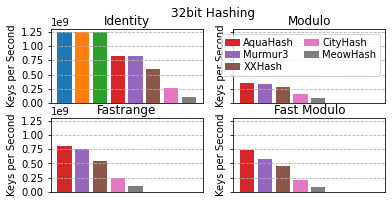

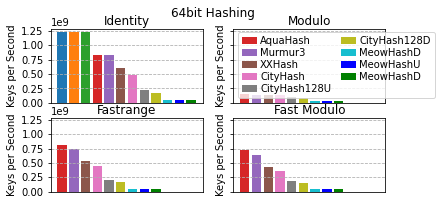

In [8]:
def plot_throughput(data, bits):
    reset_colors()
    
    cols = 2
    rows = 2
    fig, axs = plt.subplots(cols, rows, figsize=(fig_width, fig_height*rows), sharex=True, sharey=True)

    reducers =  {f'do_nothing{bits}': 0, f'modulo{bits}': 1, f'fastrange{bits}': 2, f'fast_modulo{bits}': 3}
    data = data[data[reducer_key].isin(reducers)].copy(deep=True)
    data[reducer_key] = pd.Categorical(data[reducer_key], reducers.keys())
    data = data.sort_values(by=[reducer_key, throughput_key], key=lambda x: x.map(reducers))
    for i, (reducer, df) in enumerate(data.groupby([reducer_key], sort=False)):
        ax = axs[int(i / cols)][i % rows]
        
        ax.set_title(reducer_name(reducer), pad=4)
        ax.set_ylabel("Keys per Second")
        ax.set_yticks(np.arange(0, 1.5 * 10**9, 0.25 * 10**9))
        ax.tick_params(
            axis='x',
            which='both',
            top=False, 
            bottom=False, 
            labelbottom=False)
        ax.grid(linestyle="--", axis="y")

        df = df.sort_values(by=[order_key])
        for j, (name, d) in enumerate(df.groupby([hash_key], sort=False)):
            ax.bar(data=d, x=j, label=hashfn_name(name), color=get_color(name), height=throughput_key)
            
    # legend in top right plot
    axs[0][1].legend(loc="best", ncol=2, borderpad=0.4, labelspacing=0.2, handlelength=1.5, handletextpad=0.3, columnspacing=1.0)
    
    # overall title
    fig.suptitle(f"{bits}bit Hashing")
    
    fig.savefig(f"throughput_{compiler}_{bits}.pdf", bbox_inches="tight", dpi=300)
    # fig.savefig(f"throughput_hash_{compiler}_{bits}.pgf", bbox_inches="tight", dpi=300)

plt.close('all')
plot_throughput(th_df, 32)
plot_throughput(th_df, 64)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


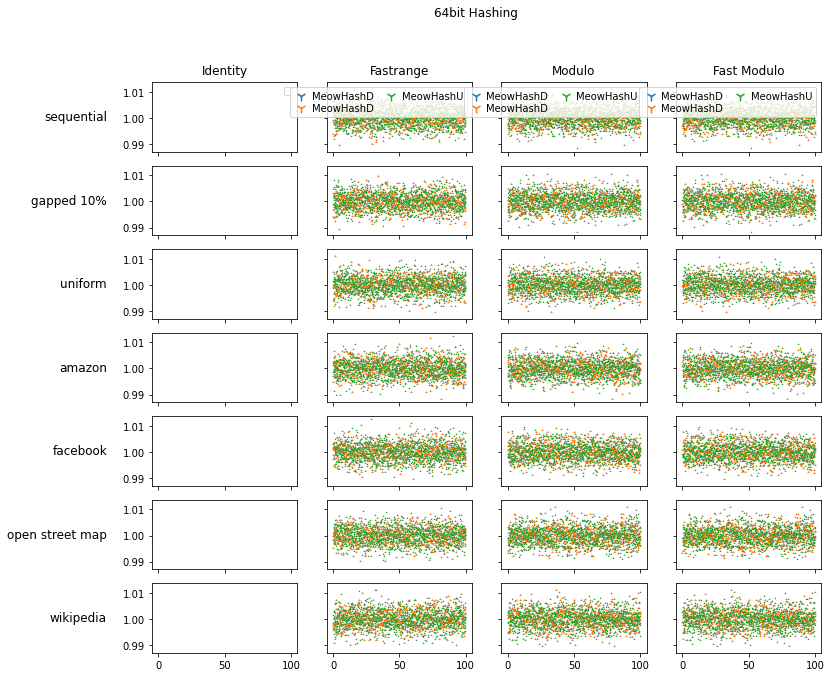

In [20]:
def plot_collisions(data, bits):
    reset_colors()
    
    cols = 7
    rows = 4
    
    # TODO: remove 2x
    fig, axs = plt.subplots(cols, rows, figsize=(fig_width*2, cols*fig_height), sharex=True, sharey=True)

    reducers =  {f'do_nothing{bits}': 0, f'fastrange{bits}': 1, f'modulo{bits}': 2, f'fast_modulo{bits}': 3}
    data = data[data[reducer_key].isin(reducers)].copy(deep=True)
    data[reducer_key] = pd.Categorical(data[reducer_key], reducers.keys())
    data = data.sort_values(by=[reducer_key, throughput_key], key=lambda x: x.map(reducers))
    for i, (dataset, df) in enumerate(data.groupby([dataset_key], sort=False)):
        pad = 7.5
        axs[i][0].annotate(dataset_name(dataset), xy=(0, 0.5), xytext=(-axs[i][0].yaxis.labelpad - pad, 0),
                    xycoords=axs[i][0].yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center')
        
        for j, (reducer, df) in enumerate(df.groupby([reducer_key], sort=False)):            
            ax = axs[i][j]

            # ax.set_ylim([0.95, 1.05])
            # ax.tick_params(
            #     axis='x',
            #     which='both',
            #     top=False, 
            #     bottom=False, 
            #     labelbottom=False)

            for _, baseline in df.iterrows():
                name = baseline[hash_key]
                
                if not name.startswith("meow"):
                    continue
                
                bucket_cnt = int(baseline[buckets_key])
                expected_per_bucket = float(baseline[dataset_size_key])/float(baseline[buckets_key])
                normalized_collisions = [float(baseline[f"bucket_{k}"])/expected_per_bucket for k in range(bucket_cnt)]
                ax.scatter(np.arange(0, 100.0, 100.0 / bucket_cnt), normalized_collisions, color=get_color(name), label=hashfn_name(name), s=1, marker='1')
            
            if i == 0:
                ax.annotate(reducer_name(reducer), xy=(0.5, 1), xytext=(0, pad), xycoords='axes fraction', textcoords='offset points', size='large', ha='center', va='baseline')
                ax.legend(markerscale=10, loc="best", ncol=2, borderpad=0.4, labelspacing=0.2, handlelength=1.5, handletextpad=0.3, columnspacing=1.0)
            
    
    # overall title
    fig.suptitle(f"{bits}bit Hashing")
    
    fig.savefig(f"collision_{compiler}_{bits}.pdf", bbox_inches="tight", dpi=300)
    # fig.savefig(f"throughput_hash_{compiler}_{bits}.pgf", bbox_inches="tight", dpi=300)

plt.close('all')
# plot_collisions(co_df, 32)
plot_collisions(co_df, 64)